In [303]:
import pandas as pd
import numpy as np
df = pd.read_csv('2022_Competition_Training.csv')
# drop error value
df.drop(df.loc[df['cms_race_cd']=='*'].index,inplace=True)

# change the datatype
df['cms_race_cd']=pd.to_numeric(df['cms_race_cd'])
df['cons_homstat']=df['cons_homstat'].fillna('U')
'''
for index, row in df.iterrows():
    if(df.loc[index,'rucc_category'][2]=='M'):
        df.loc[index,'rucc_category']=1
    else:
        df.loc[index,'rucc_category']=0
'''

# one-hot encoding
df = df.join(pd.get_dummies(df['cms_race_cd'],prefix="cms_race_cd"))
df = df.join(pd.get_dummies(df['sex_cd'],prefix="sex"))
df = df.join(pd.get_dummies(df['rucc_category'],prefix="rucc_category"))
df = df.join(pd.get_dummies(df['cms_orig_reas_entitle_cd'],prefix="cms_orig_reas_entitle_cd"))
df = df.join(pd.get_dummies(df['cons_homstat'],prefix="cons_homstat"))
df.drop(columns = ['sex_cd','cms_race_cd','cms_orig_reas_entitle_cd','rucc_category','cons_homstat'],axis=1,inplace=True)
df.drop(columns = ['sex_M','rucc_category_9-Nonmetro','cms_race_cd_6',
                   'cms_orig_reas_entitle_cd_2.0','cons_homstat_T'],axis=1,inplace=True)

# drop columns with more than 5% missing values
for col in df.columns:
    not_null_sum = len(df[col][df[col]==df[col]]) # number of missing values
    if (not_null_sum < 48293*0.95):
        df.drop(col,axis=1,inplace=True)

# fill in missing values with mean for numerical data
for col in df.columns:
    if (col in ("cons_mobplus","cms_ra_factor_type_cd",
                "cons_homstat","cms_orig_reas_entitle_cd","sex_cd",
               "lang_spoken_cd","rucc_category","cms_race_cd")):
        print(col)
        next
    else:
        df[col]=df[col].fillna(df[col].mean())

# set training set and test set
def cap_data(df):
    for col in df.columns:
        #print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

#df=cap_data(df)
from sklearn.model_selection import train_test_split

y = df['hi_flag']
X = df.drop(['hi_flag','id'],axis=1)

/Users/wangsixuan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (760) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [304]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state =34 )



In [306]:
from sklearn.utils import resample
train_set=pd.concat([x_train,y_train],axis=1)
zero  = train_set[train_set['hi_flag']==0]   
one = train_set[train_set['hi_flag']==1]
train_set_minority_upsampled = resample(one, replace = True, n_samples = 36956,random_state = 3)
train_set = pd.concat([zero, train_set_minority_upsampled])

y_train2=train_set['hi_flag']
x_train2=train_set.drop(['hi_flag'],axis=1)

In [308]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

model_lgb_goss = lgb.LGBMClassifier(boosting_type='goss',n_estimators=40,num_leaves=15,learning_rate=0.11,max_depth=-1)
model_lgb_goss.fit(x_train2, y_train2)
y_pred_lgb =model_lgb_goss.predict_proba(x_test)
print(roc_auc_score(y_test,y_pred_lgb[:,1]))
y_pred_lgb =model_lgb_goss.predict(x_test)
print(roc_auc_score(y_test,y_pred_lgb))

0.7456400259909032
0.6811357005440252


/Users/wangsixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/Users/wangsixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


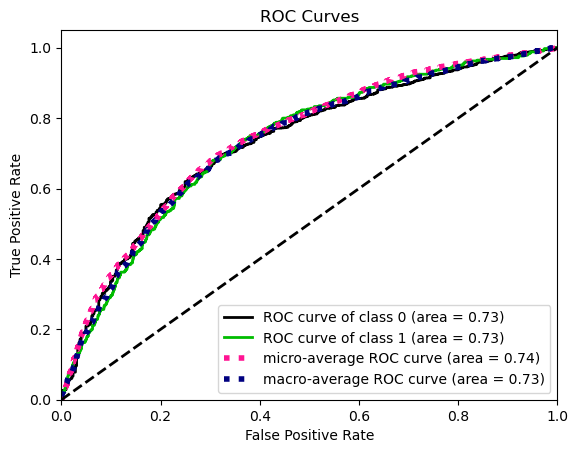

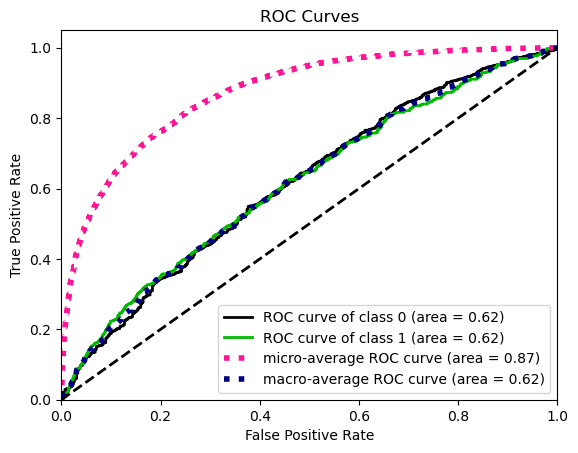

In [172]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc_curve(y_test, y_pred_xgb)
skplt.metrics.plot_roc_curve(y_test, y_pred_lgb)
plt.show()
#np.concatenate((1-y_probas,y_probas),axis=1)

In [309]:
ho = pd.read_csv('2022_Competition_Holdout.csv')
# drop error value
ho.drop(ho.loc[ho['cms_race_cd']=='*'].index,inplace=True)

# change the datatype
# 'cms_race_cd'这个column本来type是乱掉的（mixed type），先统一成numerical，再改成category。
ho['cms_race_cd']=pd.to_numeric(ho['cms_race_cd'])
ho['cons_homstat']=ho['cons_homstat'].fillna('U')
'''
for index, row in ho.iterrows():
    if(ho.loc[index,'rucc_category'][2]=='M'):
        ho.loc[index,'rucc_category']=1
    else:
        ho.loc[index,'rucc_category']=0
'''

# one-hot encoding
ho = ho.join(pd.get_dummies(ho['cms_race_cd'],prefix="cms_race_cd"))
ho = ho.join(pd.get_dummies(ho['sex_cd'],prefix="sex"))
ho = ho.join(pd.get_dummies(ho['rucc_category'],prefix="rucc_category"))
ho = ho.join(pd.get_dummies(ho['cms_orig_reas_entitle_cd'],prefix="cms_orig_reas_entitle_cd"))
ho = ho.join(pd.get_dummies(ho['cons_homstat'],prefix="cons_homstat"))
ho.drop(columns = ['sex_cd','cms_race_cd','cms_orig_reas_entitle_cd','rucc_category','cons_homstat'],axis=1,inplace=True)
ho.drop(columns = ['sex_M','rucc_category_9-Nonmetro','cms_race_cd_6',
                   'cms_orig_reas_entitle_cd_2.0','cons_homstat_T'],axis=1,inplace=True)

# drop columns with more than 5% missing values
for col in ho.columns:
    not_null_sum = len(ho[col][ho[col]==ho[col]]) # number of missing values
    if (not_null_sum < 12220*0.95):
        ho.drop(col,axis=1,inplace=True)

# fill in missing values with mean for numerical data
for col in ho.columns:
    if (col in ("cons_mobplus","cms_ra_factor_type_cd",
                "cons_homstat","cms_orig_reas_entitle_cd","sex_cd",
               "lang_spoken_cd","rucc_category","cms_race_cd")):
        print(col)
        next
    else:
        ho[col]=ho[col].fillna(ho[col].mean())
        
X_ho = ho.drop(['id'],axis=1)

/Users/wangsixuan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (760) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
X_ho

,rx_hum_19_pmpm_cost,cmsd2_can_mal_male_genital_pmpm_ct,cmsd2_inj_surgical_pmpm_ct,rev_pm_capd_pmpm_cd_ct,cci_chf_pmpm_ct,rx_phar_cat_safeway_pmpm_ct,cmsd2_ext_car_pmpm_ct,cmsd2_dig_liver_pmpm_ct,cmsd2_mus_arthropath_pmpm_ct,rx_hum_28_pmpm_ct,...,rucc_category_6-Nonmetro,rucc_category_7-Nonmetro,rucc_category_8-Nonmetro,cms_orig_reas_entitle_cd_0.0,cms_orig_reas_entitle_cd_1.0,cms_orig_reas_entitle_cd_3.0,cons_homstat_P,cons_homstat_R,cons_homstat_U,cons_homstat_Y
0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0,0,0,0,1,0,0,0,0,1
1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0,0,0,1,0,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0,0,0,1,0,0,0,1,0,0
3,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0,0,0,1,0,0,0,0,0,1
4,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12215,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0,0,0,0,1,0,0,0,0,1
12216,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0,0,0,0,1,0,0,0,0,1
12217,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0,0,0,1,0,0,0,0,0,1
12218,0.0,0.0,0.0,0.0,0.16,0.0,0.0,0.0,0.0,0.00,...,0,0,0,1,0,0,1,0,0,0


In [310]:
y_pred_prob =model_lgb_goss.predict_proba(X_ho)

list_id=list(ho['id'])
list_score=list(y_pred_prob[:,1])
dict={"ID":list_id,"SCORE":list_score}
csv=pd.DataFrame(dict)
csv['RANK'] = csv['SCORE'].rank(ascending=False)
outputpath='/Users/wangsixuan/Desktop/bu/商赛/2022CaseCompetition_Sixuan_Wang_20221016.csv'
csv.to_csv(outputpath,sep=',',index=False,header=True)